## [Chapter 3](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_PyMC3.ipynb)

Notes and exercises from Cam Davidson's *[Probabilistic Programming and Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)*.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter
from IPython.display import display
from scipy import stats
from scipy.misc import comb as nCk
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdb

import daft
import theano.tensor as tt
import pymc3 as pm

np.random.seed(865)

'Done'

/home/alex/.envs/think-series/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'Done'

## MCMC Overview

General MCMC steps:

1. Start at current position (in parameter space)
2. Propose moving to a new position.
3. Accept or reject the new position based on the position's adherance to the data and prior distributions.
4. If you accept, move to the new position, return to step 1. If you reject, do not move to new position, return to step 1.
5. After a large number of iterations, return all accepted positions.

Memorylessness:

1. In the algorithm above, only the current position matters, regardless how it was arrived at.

## Example: Unsupervised Clustering using a Mixture Model

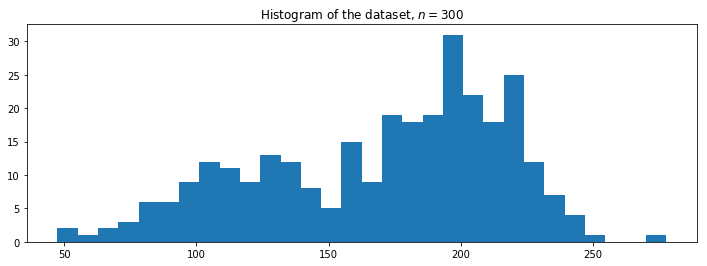

In [2]:
data = np.loadtxt('davidson/Chapter3_MCMC/data/mixture_data.csv', delimiter=",")

plt.figure(figsize=(12,4))
plt.hist(data, bins=30)
plt.title('Histogram of the dataset, $n=%d$' % len(data))
plt.show()

In [6]:
N = len(data)
K = 2           # Number of clusters (the model below will only work with K = 2)

with pm.Model() as cluster_model:
    
    p1 = pm.Uniform('p', 0, 1)   # Probability a data point belongs to cluster 1.
    p2 = 1 - p1                  # Probability a data point belongs to cluster 2.
    
    # Combine the cluster probabilities into a vector.
    # Use the vector to parameterize the assignment categorical variable,
    # which assigns draws a cluster (0 or 1) for each of the data points.
    P = tt.stack([p1, p2])
    assignment = pm.Categorical('assignment', P, shape=N, 
                                testval=np.random.randint(0, K, data.shape[0]))
        
    # Model the clusters as being normally distributed.
    # Each cluster needs a mu and sd parameter. 
    # Mu parameters start with a normal prior eye-balled from the data.
    # Sd parameters start with a less informative uniform prior.
    # Note that the below are K-dimensional vectors, i.e mus[0] and sds[0] parameterize cluster 0's Normal.
    mus = pm.Normal('mus', mu=np.array([120, 190]), sd=np.array([10, 10]), shape=K)
    sds = pm.Uniform('sds', 0, 100, shape=K)
    
    # For each data point, access the mu and sd corresponding to data point's assigned cluster.
    # Note that the below are N-dimensional vectors. i.e. mu_i[0] and sd_i[0] correspond to data point 0.
    mu_i = pm.Deterministic('mu_i', mus[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # Use each data point's mu and sd to draw a random data point.
    obs = pm.Normal('obs', mu=mu_i, sd=sd_i, observed=data)
    
    display(model)
    
    # Explore the space with separate steps for continuous and categorical variables.
    step_con = pm.Metropolis(vars=[P, mus, sds])
    step_cat = pm.ElemwiseCategorical(vars=[assignment])
    cluster_trace = pm.sample(10000, step=[step_con, step_cat])
    
'Done'

/home/alex/.envs/think-series/lib/python3.5/site-packages/ipykernel_launcher.py:36: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [sds_interval__]
>>Metropolis: [mus]
>>Metropolis: [p_interval__]
>ElemwiseCategorical: [assignment]
100%|██████████| 10500/10500 [01:48<00:00, 96.40it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


'Done'

### Inspecting the traces and posterior means; classifying

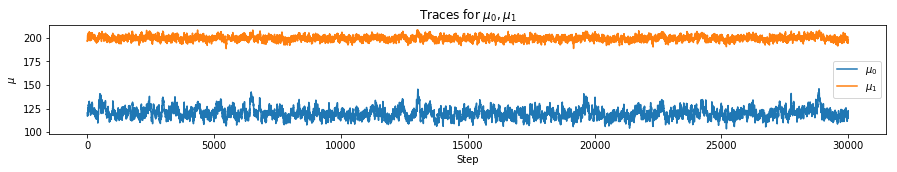

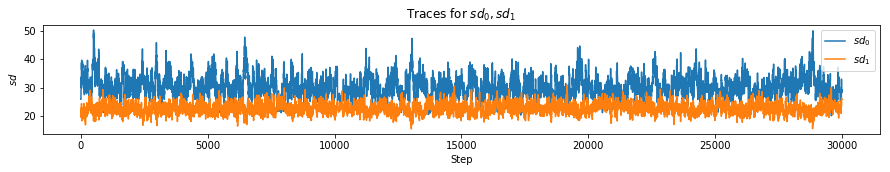

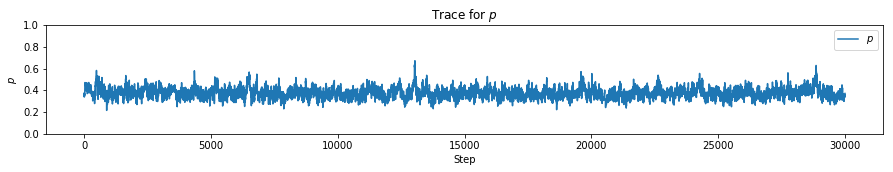

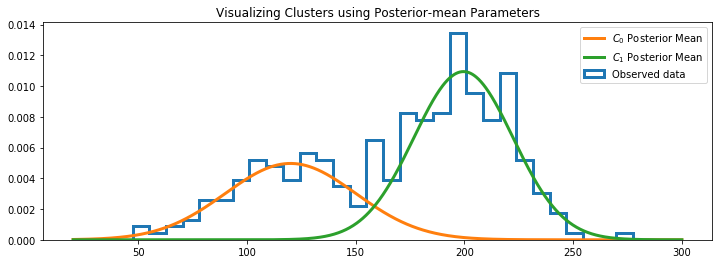

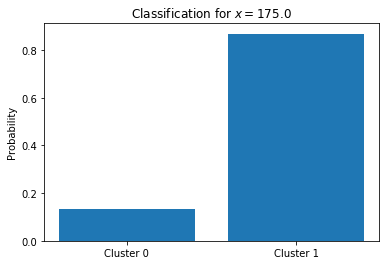

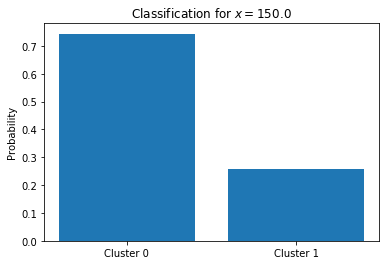

'Done'

In [7]:
def inspect_traces(cluster_trace):
    plt.figure(figsize=(15, 2))
    plt.plot(cluster_trace['mus'][:,0], label='$\mu_0$')
    plt.plot(cluster_trace['mus'][:,1], label='$\mu_1$')
    plt.title('Traces for $\mu_0, \mu_1$')
    plt.xlabel('Step')
    plt.ylabel('$\mu$')
    plt.legend()
    plt.show()

    plt.figure(figsize=(15, 2))
    plt.plot(cluster_trace['sds'][:,0], label='$sd_0$')
    plt.plot(cluster_trace['sds'][:,1], label='$sd_1$')
    plt.title('Traces for $sd_0, sd_1$')
    plt.xlabel('Step')
    plt.ylabel('$sd$')
    plt.legend()
    plt.show()

    plt.figure(figsize=(15, 2))
    plt.plot(cluster_trace['p'], label='$p$')
    plt.title('Trace for $p$')
    plt.xlabel('Step')
    plt.ylabel('$p$')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()
    
def inspect_posterior_means(cluster_trace):
    
    X = np.linspace(20, 300, 1001)

    plt.figure(figsize=(12,4))
    plt.hist(data, bins=30, histtype='step', lw=3, label='Observed data', density=True)

    c0_rv = stats.norm(cluster_trace['mus'][:,0].mean(), cluster_trace['sds'][:,0].mean())
    c0_w = cluster_trace['p'].mean()
    c0_pdf = c0_w * c0_rv.pdf(X)
    plt.plot(X, c0_pdf, lw=3, label='$C_0$ Posterior Mean')

    c1_rv = stats.norm(cluster_trace['mus'][:,1].mean(), cluster_trace['sds'][:,1].mean())
    c1_w = (1 - cluster_trace['p'].mean())
    c1_pdf = c1_w * c1_rv.pdf(X)
    plt.plot(X, c1_pdf, lw=3, label='$C_1$ Posterior Mean')

    plt.title('Visualizing Clusters using Posterior-mean Parameters')
    plt.legend()
    plt.show()
    
def classify(x, cluster_trace):
    """Classify by computing the likelihood of the given data under each
    hypothesized cluster. Then normalize the likelihoods."""
    
    c0_rv = stats.norm(cluster_trace['mus'][:,0].mean(), cluster_trace['sds'][:,0].mean())
    c0_w = cluster_trace['p'].mean()
    
    c1_rv = stats.norm(cluster_trace['mus'][:,1].mean(), cluster_trace['sds'][:,1].mean())
    c1_w = (1 - cluster_trace['p'].mean())
    
    C = np.array([c0_w * c0_rv.pdf(x), c1_w * c1_rv.pdf(x)])
    C /= C.sum()

    plt.bar(range(2), C)
    plt.title('Classification for $x=%.1lf$' % x)
    plt.xticks([0, 1], ['Cluster 0', 'Cluster 1'])
    plt.ylabel('Probability')
    plt.show()

    return C


inspect_traces(cluster_trace)
inspect_posterior_means(cluster_trace)
classify(175, cluster_trace)
classify(150, cluster_trace)

'Done'

### Using MAP to improve convergence

In [13]:
with cluster_model:
    
    # Explore the space with separate steps for continuous and categorical variables.
    start = pm.find_MAP()
    step_con = pm.Metropolis(vars=[P, mus, sds])
    step_cat = pm.ElemwiseCategorical(vars=[assignment])
    cluster_trace_MAP = pm.sample(1000, step=[step_con, step_cat], start=start)
    
'Done'

logp = -1,810, ||grad|| = 4.1011: 100%|██████████| 29/29 [00:00<00:00, 841.65it/s]    
/home/alex/.envs/think-series/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  
Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [sds_interval__]
>>Metropolis: [mus]
>>Metropolis: [p_interval__]
>ElemwiseCategorical: [assignment]
100%|██████████| 1500/1500 [00:16<00:00, 92.09it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


'Done'

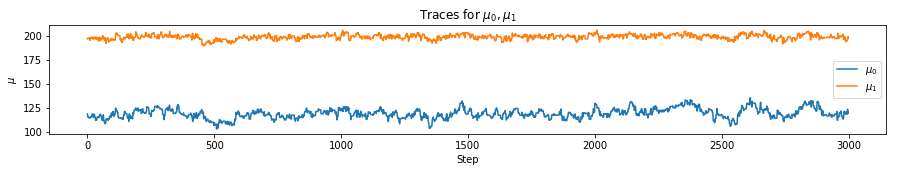

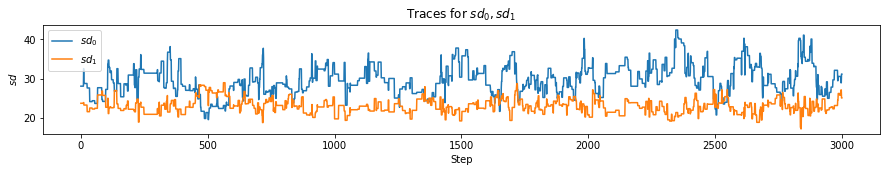

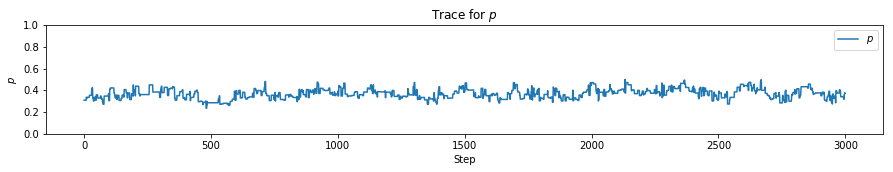

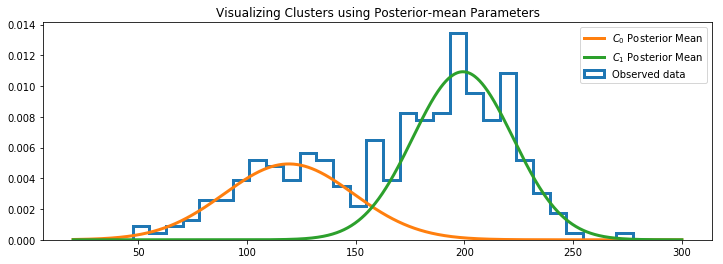

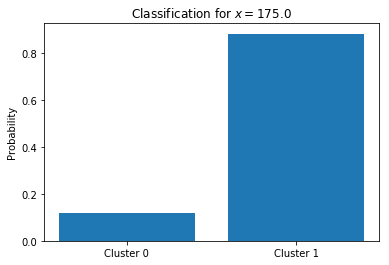

array([0.11937905, 0.88062095])

In [15]:
inspect_traces(cluster_trace_MAP)
inspect_posterior_means(cluster_trace_MAP)
classify(175, cluster_trace_MAP)

## A bit about Autocorrelation

- A chain that is exploring the space well (meandering like a river) will exhibit high autocorrelation.
- Low autocorrelation is not necessary for convergence, but is sufficient.

## A bit about Thinning

- Many post-processing algorithms require samples to be independent of each other, which is not the case with high autocorrelation.
- This can be addressed by only returning every $n$-th sample. As $n$ increases, the autocorrelation for corresponding $k$ (autorcorrelation lag) will be smaller.

## `pymc3.plots`

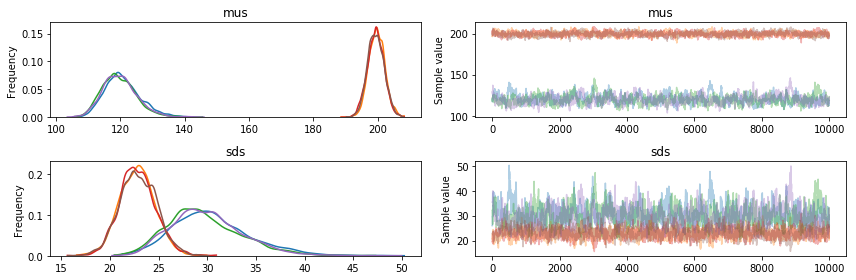

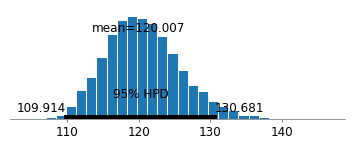

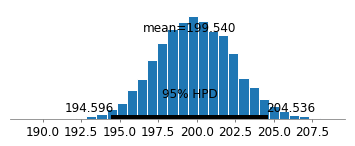

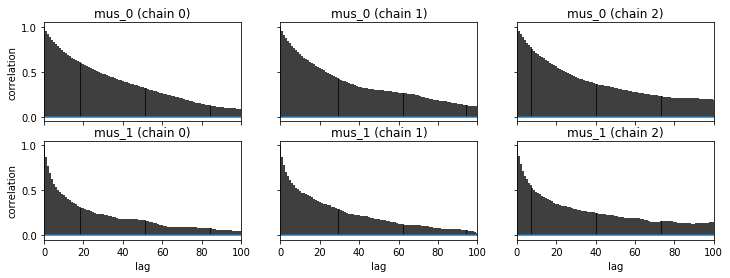

In [24]:
pm.plots.traceplot(trace=cluster_trace, varnames=['mus', 'sds'])
pm.plots.plot_posterior(trace=cluster_trace['mus'][:, 0])
pm.plots.plot_posterior(trace=cluster_trace['mus'][:, 1])
pm.plots.autocorrplot(trace=cluster_trace, varnames=['mus'])
plt.show()